In [ ]:
# !cp /kaggle/input/data-bowl-2019-external-data/*.py /kaggle/working

In [70]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
import jupytools.syspath
def ignore(*args, **kwargs): pass
warnings.warn = ignore
jupytools.syspath.add('..')

In [71]:
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold

import selection
import utils as U
from metric import optimize_rounding_bounds, make_cappa_metric
from training import EnsembleTrainer, get_default_config

In [72]:
non_train_cols = ['installation_id', 'game_session', 'accuracy_group']

def read_dataset():
    X_trn = pd.read_pickle('/tmp/X_trn.pickle')
    X_tst = pd.read_pickle('/tmp/X_tst.pickle')
    selector = selection.FeatureSelection(
        rules=[('nonzero', selection.non_zero_rows_and_cols)],
        ignore_cols=non_train_cols)
    features = selector.select(X_trn)
    X_trn['is_test'] = 0
    X_tst['is_test'] = 1
    dataset = pd.concat([X_trn, X_tst])
    return dataset, features

## Adversarial CV

In [ ]:
# https://www.kaggle.com/poteman/sampling-train-data-and-use-prediction-as-feature

In [73]:
def accuracy(y_true, y_pred, t=0.5):
    from sklearn.metrics import balanced_accuracy_score
    y_hat = [0 if y < t else 1 for y in y_pred]
    return balanced_accuracy_score(y_true, y_hat)

In [74]:
def adv_cv(dataset, features, algo='lightgbm', target='is_test', config=None):
    trainer = EnsembleTrainer(
        algo=algo, eval_metric='rmse', 
        cv_metrics={'auc': roc_auc_score, 'acc': accuracy})
    fold = GroupKFold(n_splits=5)
    config = config or get_default_config(algo)
    U.set_nested(config, 'model_params.feature_fraction', 0.8)
    U.set_nested(config, 'model_params.bagging_fraction', 0.75)
    U.set_nested(config, 'model_params.bagging_freq', 1)
    result = trainer.train(dataset, features, fold, target=target)
    return result

In [75]:
def plot_feat_imp(fi, n=200, figsize=(45, 15)):
    f, ax = plt.subplots(1, 1, figsize=figsize, facecolor='white')
    fi.sort_values(ascending=False).head(n).plot.bar(ax=ax)
    ax.set_title('Most Important Features Different Between Train and Test ')

## Train As Is

In [76]:
dataset, features = read_dataset()
result_default = adv_cv(dataset, features)

Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 979 of 1000
Keeping only features, selected by every rule.
Final number of features changed from 1000 to 979
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.135736	val's rmse: 0.149029
[200]	trn's rmse: 0.10885	val's rmse: 0.132257
[300]	trn's rmse: 0.0978717	val's rmse: 0.130319
[400]	trn's rmse: 0.0907512	val's rmse: 0.130473
Early stopping, best iteration is:
[338]	trn's rmse: 0.0948317	val's rmse: 0.130132
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.137823	val's rmse: 0.142207
[200]	trn's rmse: 0.111276	val's rmse: 0.126731
[300]	trn's rmse: 0.100227	val's rmse: 0.125066
[400]	trn's rmse: 0.0931461	val's rmse: 0.125064
Early stopping, best iteration is:
[322]	trn's rmse: 0.0984824	val's rmse: 0.124994
Running k-fold 3 of 5
T

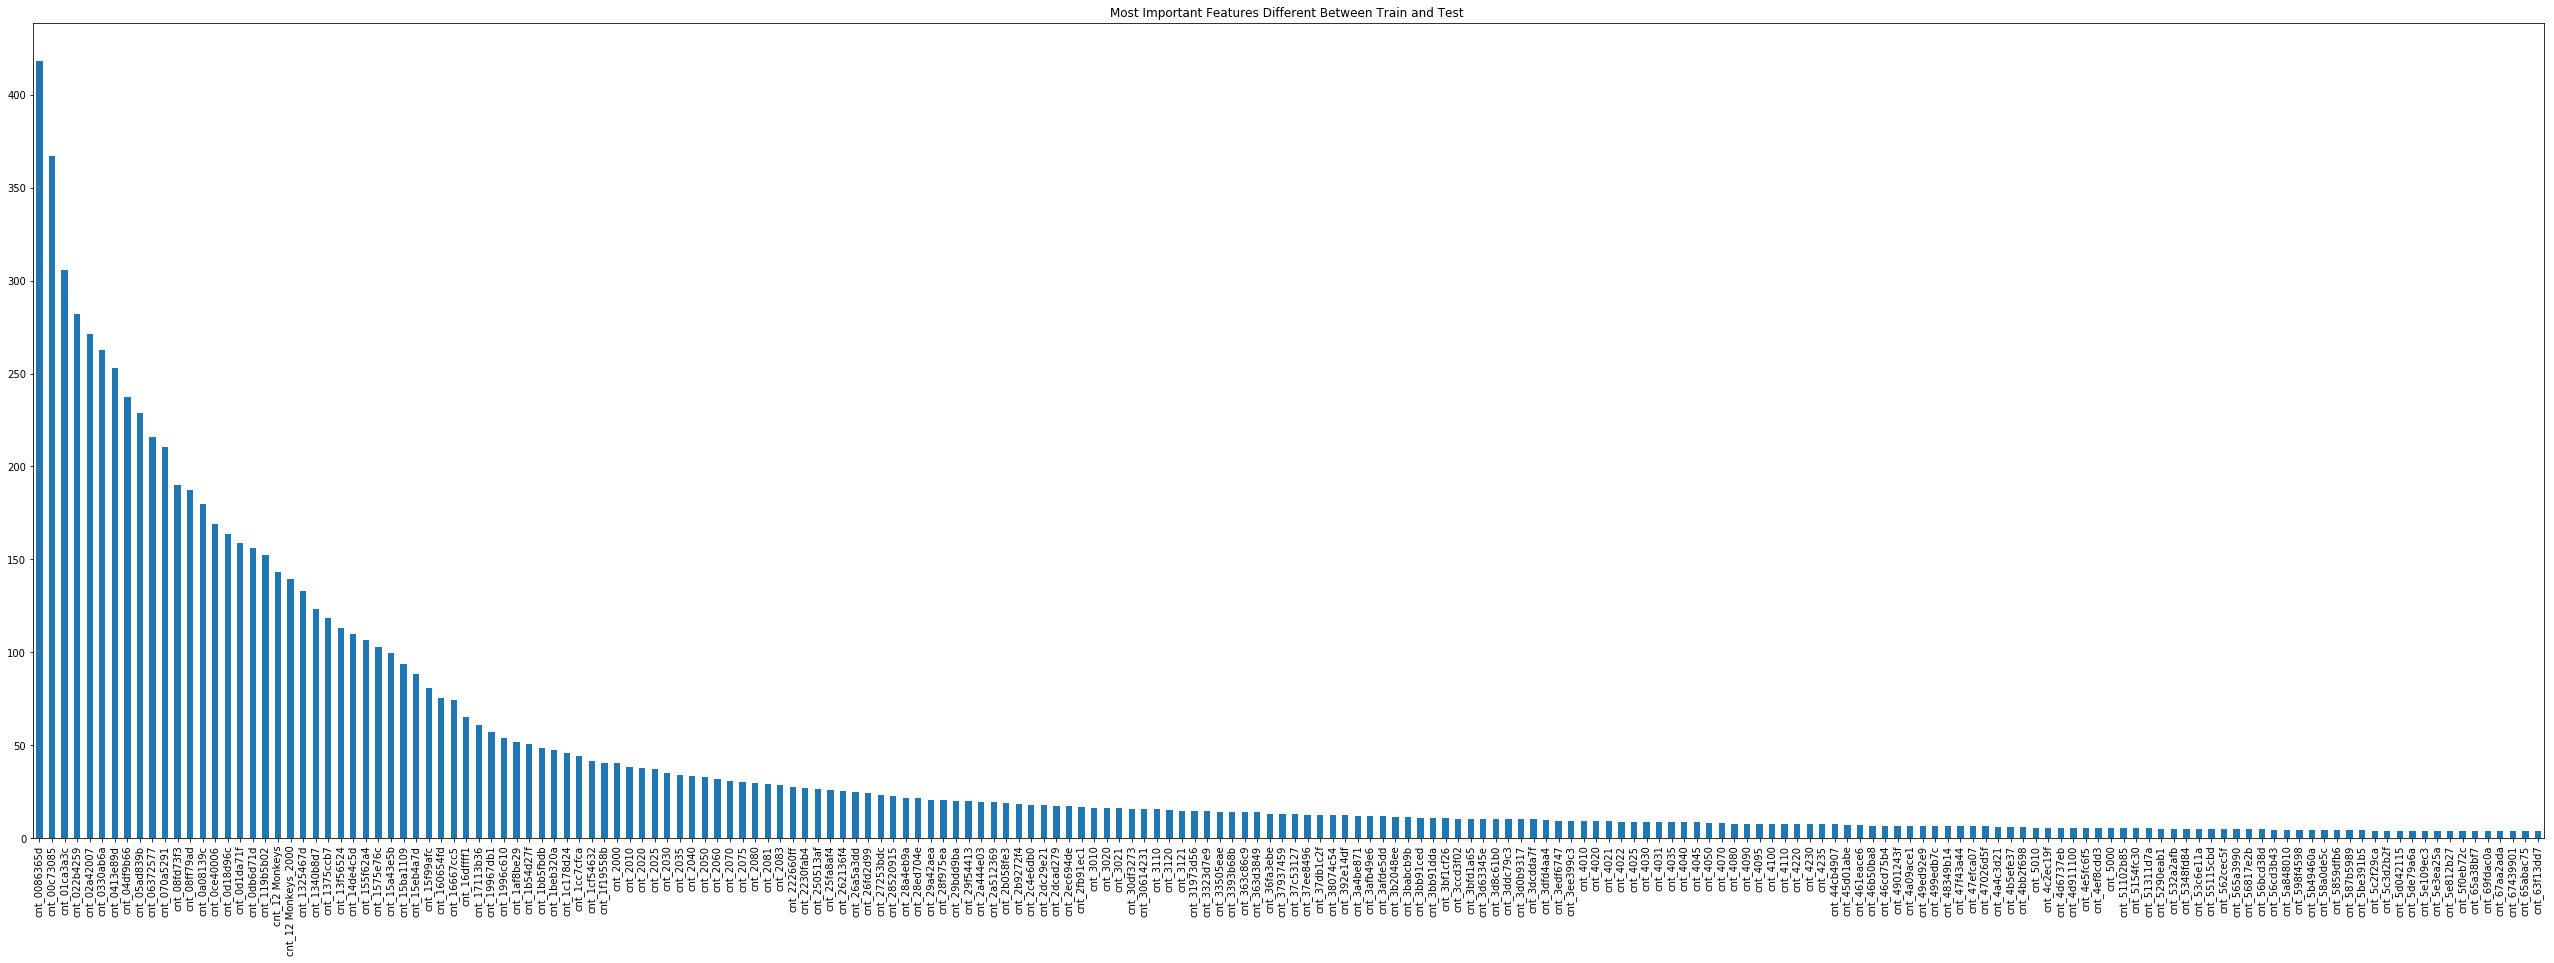

In [77]:
plot_feat_imp(result_default.fi)

## Train With Standard Scaler

In [83]:
def standard_scaler(dataset, features, stats=None):
    stats = stats or {}
    for feature in features:
        if feature not in stats:
            m = dataset[feature].mean()
            s = dataset[feature].std() + 1e-8
            stats[feature] = {'mean': m, 'std': s}
        dataset[feature] = (dataset[feature] - stats[feature]['mean'])/stats[feature]['std']

In [85]:
dataset, features = read_dataset()
cnt_features = U.starts_with(features, 'cnt_')
standard_scaler(dataset, cnt_features)
result_std = adv_cv(dataset, features)

Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 979 of 1000
Keeping only features, selected by every rule.
Final number of features changed from 1000 to 979
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.135851	val's rmse: 0.149037
[200]	trn's rmse: 0.108907	val's rmse: 0.132182
[300]	trn's rmse: 0.0979937	val's rmse: 0.130499
[400]	trn's rmse: 0.0909648	val's rmse: 0.130817
Early stopping, best iteration is:
[346]	trn's rmse: 0.0945109	val's rmse: 0.130329
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.137842	val's rmse: 0.142271
[200]	trn's rmse: 0.111327	val's rmse: 0.127362
[300]	trn's rmse: 0.100263	val's rmse: 0.125283
[400]	trn's rmse: 0.0931696	val's rmse: 0.125248
Early stopping, best iteration is:
[326]	trn's rmse: 0.098185	val's rmse: 0.125222
Running k-fold 3 of 5
T

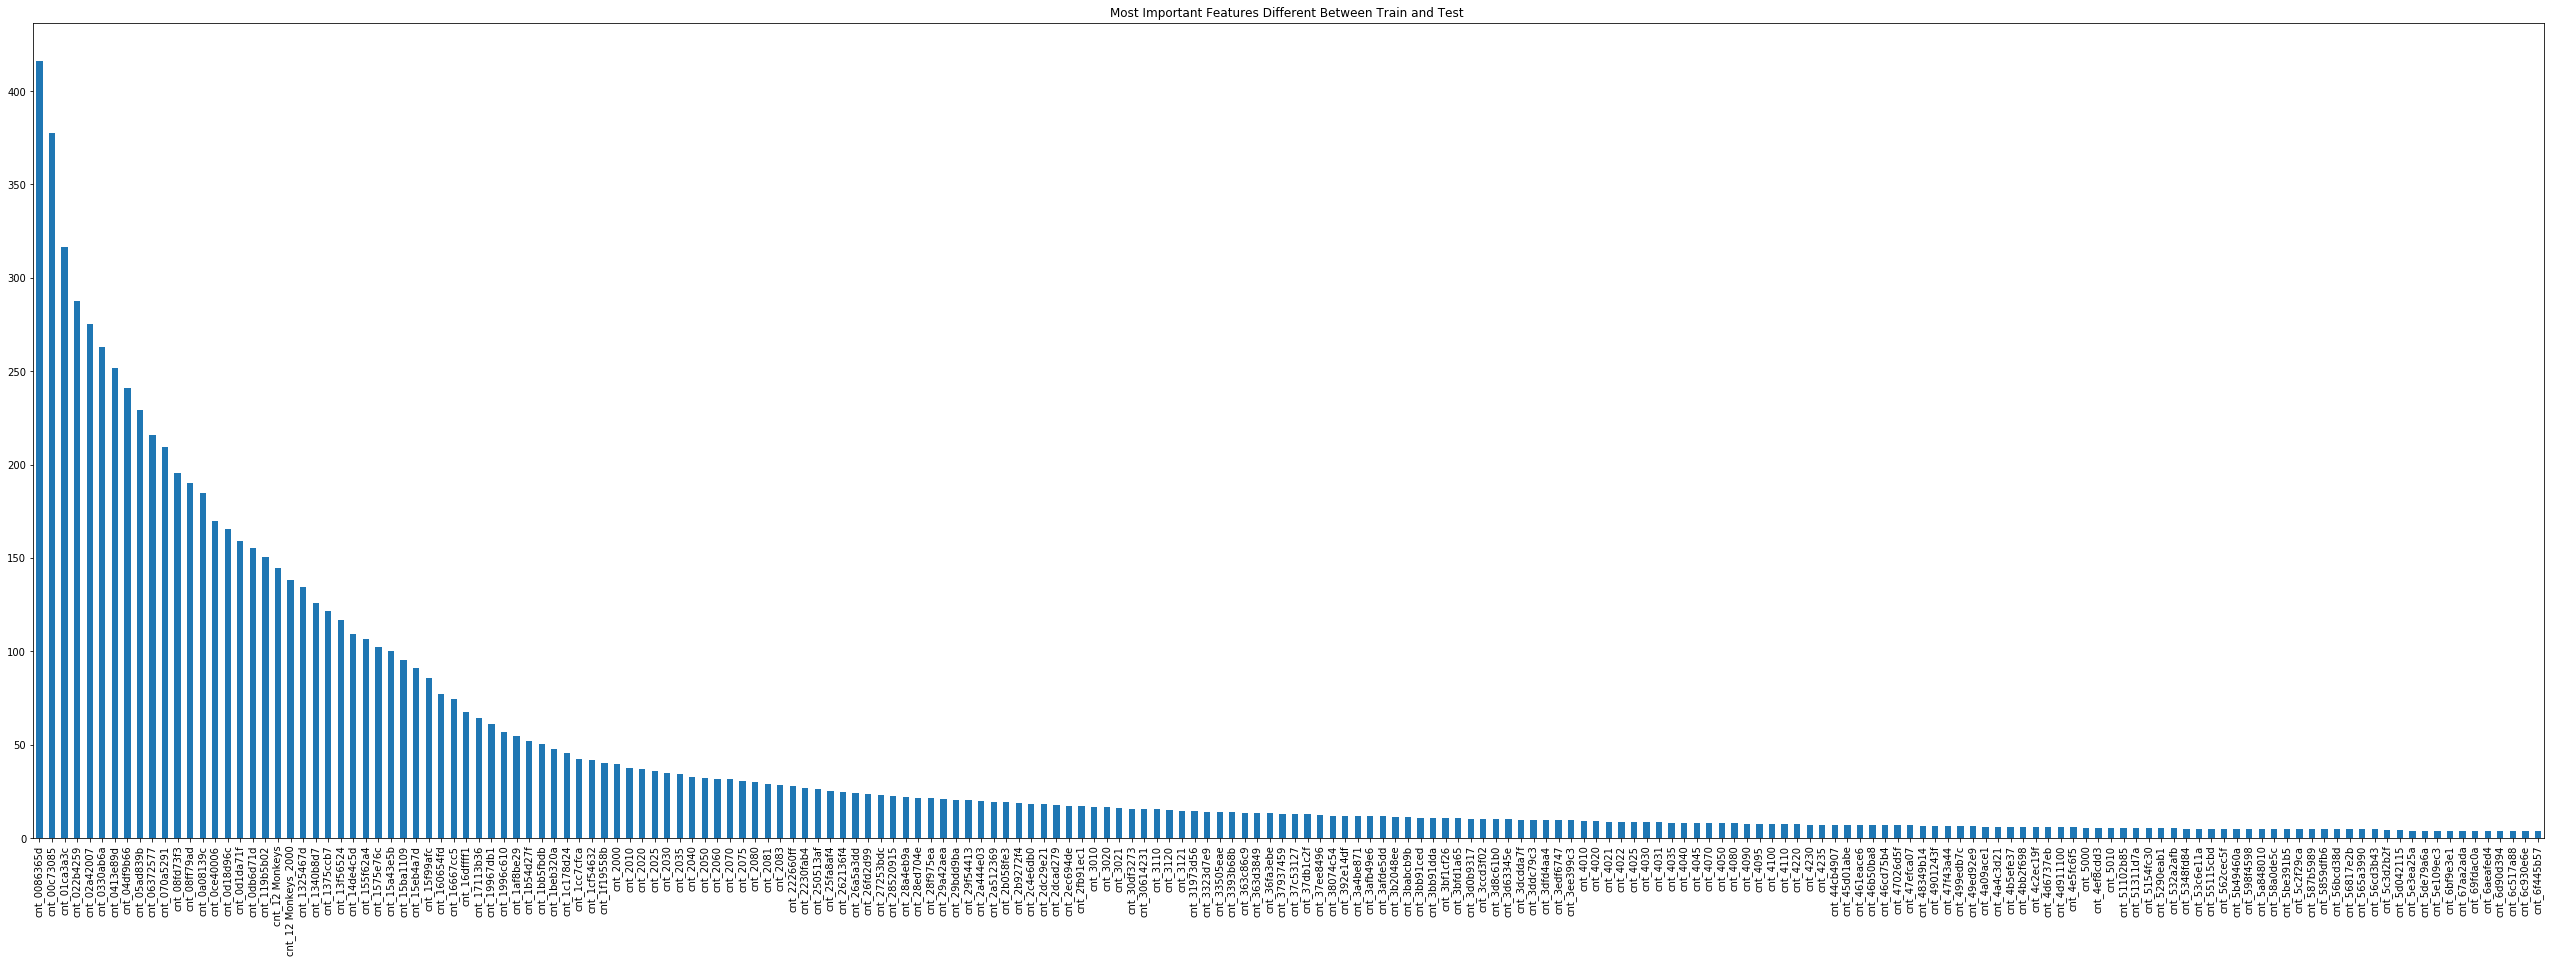

In [86]:
plot_feat_imp(result_std.fi)

## Train With Grouped Normalization: Session Title

In [87]:
def standard_scaler_grouped(dataset, features, grouping_key='session_title'):
    def _standard_scaler(x):
        m, s = x.mean(), x.std()
        return (x - m)/(s + 1e-8)
    groups = dataset.groupby(grouping_key)
    for feature in features:
        dataset[feature] = groups[feature].transform(_standard_scaler)

In [88]:
dataset, features = read_dataset()
cnt_features = U.starts_with(features, 'cnt_')
standard_scaler_grouped(dataset, cnt_features)
result_std_grouped = adv_cv(dataset, features)

Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 979 of 1000
Keeping only features, selected by every rule.
Final number of features changed from 1000 to 979
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.135801	val's rmse: 0.150711
[200]	trn's rmse: 0.107723	val's rmse: 0.133589
[300]	trn's rmse: 0.0959247	val's rmse: 0.131676
Early stopping, best iteration is:
[292]	trn's rmse: 0.0966954	val's rmse: 0.131577
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 0.138182	val's rmse: 0.143324
[200]	trn's rmse: 0.1105	val's rmse: 0.127191
[300]	trn's rmse: 0.0988164	val's rmse: 0.125276
[400]	trn's rmse: 0.091364	val's rmse: 0.12522
Early stopping, best iteration is:
[353]	trn's rmse: 0.0946333	val's rmse: 0.125146
Running k-fold 3 of 5
Training until validation scores don't improve for 1

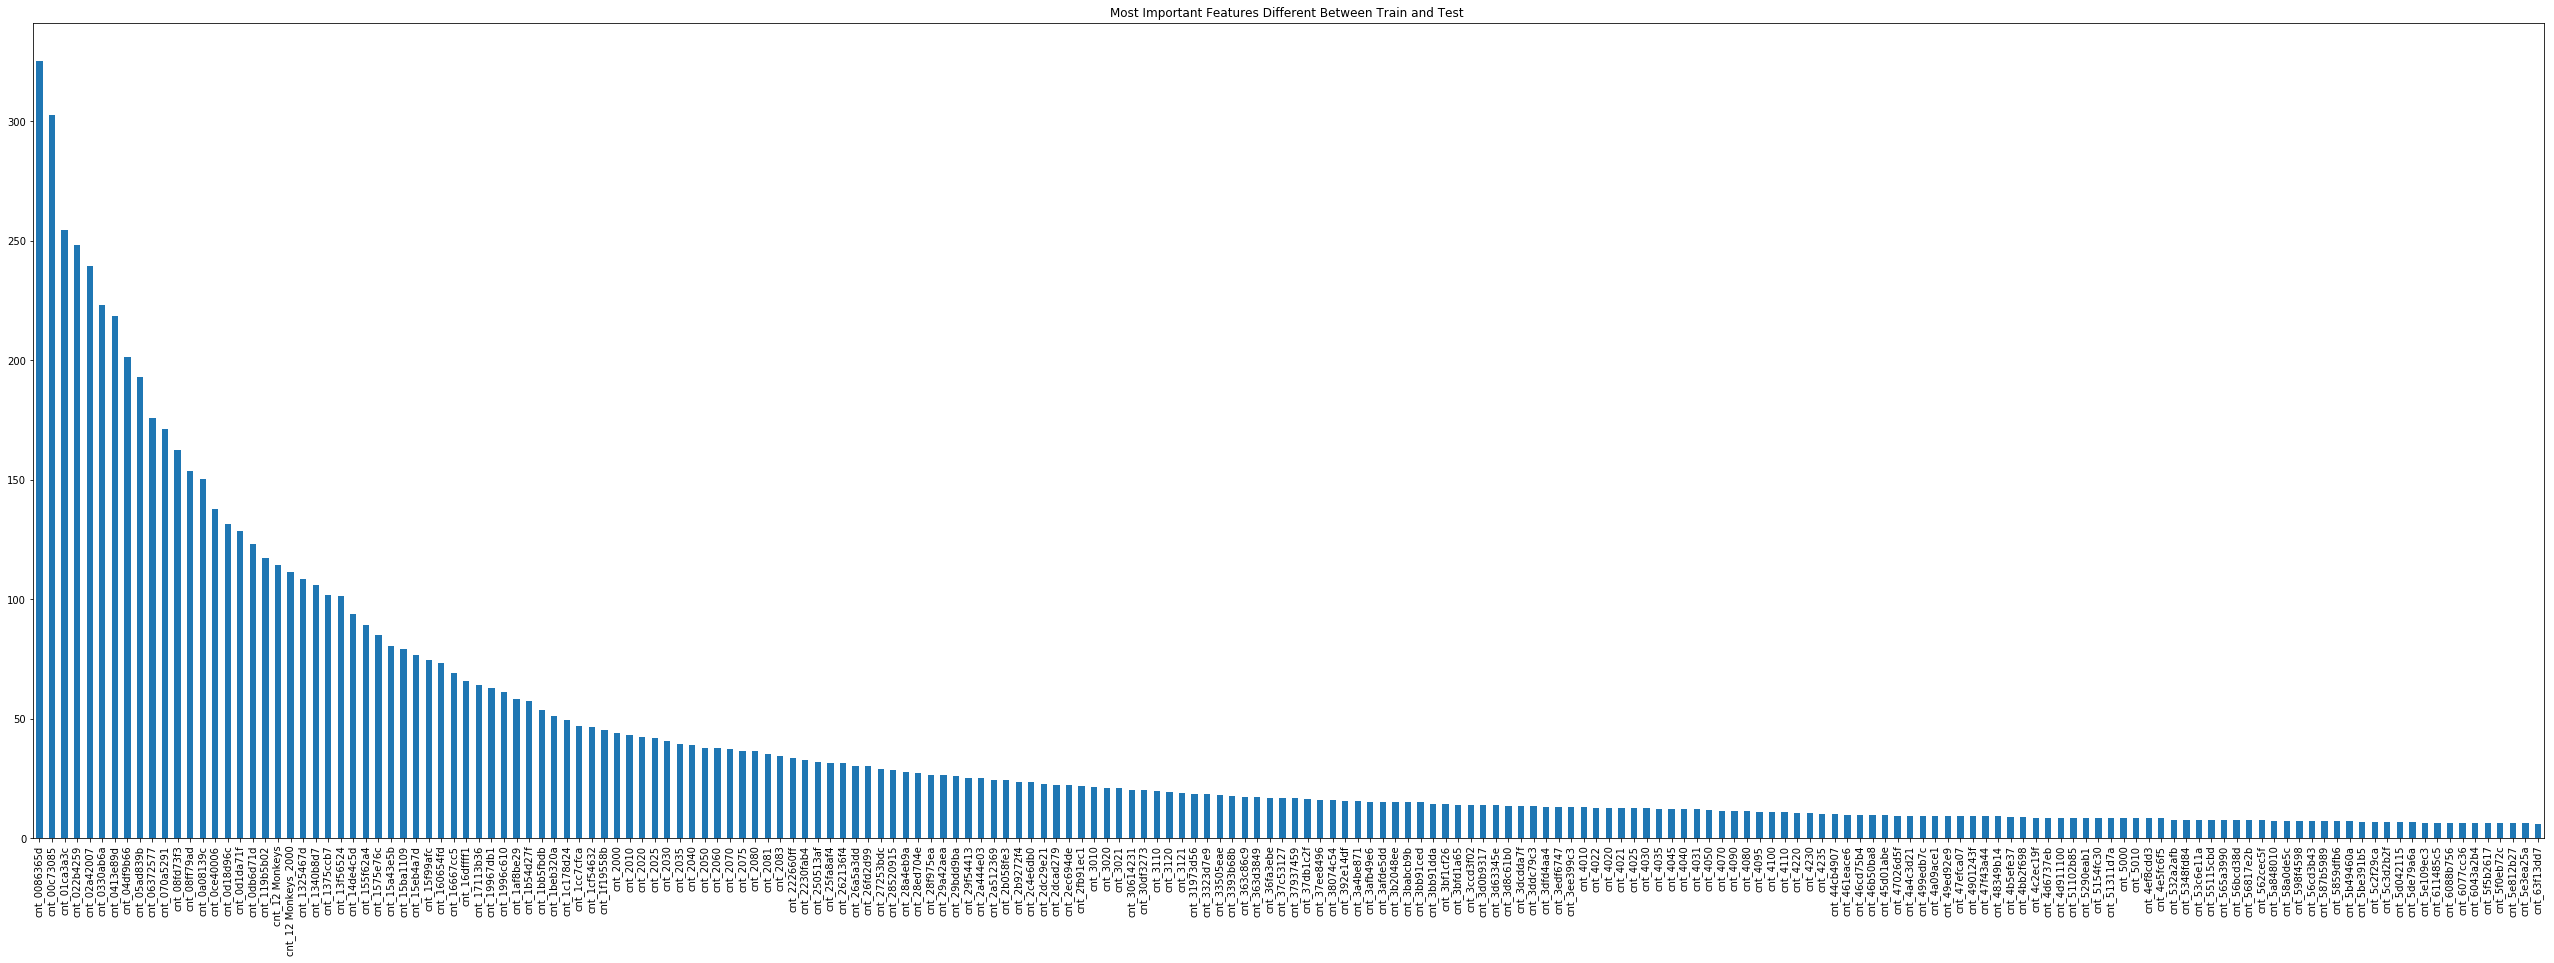

In [89]:
plot_feat_imp(result_std_grouped.fi)

## Train With Grouped Normalization: Installation ID

In [ ]:
dataset, features = read_dataset()
cnt_features = U.starts_with(features, 'cnt_')
standard_scaler_grouped(dataset, cnt_features, grouping_key='installation_id')
result_std_inst = adv_cv(dataset, features)

Excluding from consideration: ['installation_id', 'game_session', 'accuracy_group']
Applying feature selection rule: nonzero
Selected features: 979 of 1000
Keeping only features, selected by every rule.
Final number of features changed from 1000 to 979


In [ ]:
plot_feat_imp(result_std_inst.fi)